In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# reading the data
data_path = "./data/data.csv"
df = pd.read_csv(data_path, header=0)
# removing columns with NaN values 
df.dropna(axis=1, inplace=True)
# handling diagnosis feature
df['diagnosis'].replace(['M', 'B'],[0, 1], inplace=True)
# dropping the id column
df.drop(["id"], axis=1, inplace=True)


X = df.drop(["diagnosis"], axis=1)
y = df["diagnosis"]

# splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# standardizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [110]:
# Doing grid search on sklearns SVC

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

c_values = np.arange(0.5, 10.5, 0.5)
degree_values = np.arange(2,8,1)

param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': c_values,
    'degree': degree_values,  # only for 'poly' kernel
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1.0, 10.0]  # only for 'rbf' kernel
}

svm_classifier = SVC()
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters (Grid Search):", grid_search.best_params_)
print("Best accuracy (Grid Search):", grid_search.best_score_)
print()
# getting the best svm model and testing it on test data
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Best Parameters (Grid Search): {'C': 7.5, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
Best accuracy (Grid Search): 0.9846153846153847

Accuracy: 0.9824561403508771
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        47
           1       0.97      1.00      0.99        67

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [111]:
# MY SVM IMPLEMENTATION

class MySVM:
    def __init__(self, kernel='linear', d=3, sigma=1.0):
        self.kernel = kernel # type of kernel (linear, poly, rbf)
        self.d = d # degree for poly kernels
        self.sigma = sigma # sigma for rbf kernels
        self.alpha = None
        self.X_train = None

    def linear_kernel(self, X1, X2):
        # calculating linear kernel
        return np.dot(X1, X2.T)

    def poly_kernel(self, X1, X2):
        # calculating poly kernel
        return (np.dot(X1, X2.T) + 3) ** self.d

    def rbf_kernel(self, X1, X2):
        # calculating rbf kernel
        return np.exp(- (np.linalg.norm(X1[:, np.newaxis] - X2, axis=2) ** 2) / 2 * self.sigma ** 2)

    def kernel_matrix(self, X1, X2):
        if self.kernel == 'linear':
            return self.linear_kernel(X1, X2)
        elif self.kernel == 'poly':
            return self.poly_kernel(X1, X2)
        elif self.kernel == 'rbf':
            return self.rbf_kernel(X1, X2)

    def fit(self, X, y):
        if not (isinstance(X, np.ndarray)):
            X = np.array(X)
            y = np.array(y)
        # adding intercept to X
        X = np.c_[np.ones(X.shape[0]), X]
        self.X_train = X
        # computing the kernel matrix (linear kernel)
        K = self.kernel_matrix(X,X)
        # inverting the kernel matrix
        # adding small number and identity to it to insure it's invertable
        K_inv = np.linalg.inv(K + 1e-6 * np.eye(K.shape[0]))
        # calculating alpha
        self.alpha = np.dot(K_inv, y)

    def predict(self, X):
        if not (isinstance(X, np.ndarray)):
            X = np.array(X)
        # adding intercept to X
        X = np.c_[np.ones(X.shape[0]), X]
        # computing the kernel matrix
        K = self.kernel_matrix(X, self.X_train)
        y_pred = np.dot(K, self.alpha)
        #y_pred = np.where(y_pred > 0.5, 1, 0)
        return y_pred

#my_SVM = MySVM(kernel="linear")
#my_SVM.fit(X_train, y_train)
#y_pred = my_SVM.predict(X_test)

#report = classification_report(y_test, y_pred)
#accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy)
#print("Classification Report:\n", report)

In [112]:
# reading the data from Ucilnica

# reading the data
data_path = "./data/data_2.csv"
df = pd.read_csv(data_path, header=0)
df.drop(df.columns[0], axis=1, inplace=True)

X = df.drop(["y"], axis=1)
y = df["y"]

# splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# standardizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

df.head()

,x,y
0,1.00,25.882522
1,1.25,21.573761
2,1.50,18.780320
3,1.75,17.122230
4,2.00,15.616773


In [116]:
# testing my SVM on data from ucilnica
my_SVM = MySVM(kernel="rbf", sigma=1)
my_SVM.fit(X_train, y_train)
y_pred = my_SVM.predict(X_test)

from sklearn.metrics import r2_score
print(f"R2 score for my kernel regression: {r2_score(y_pred=y_pred, y_true=y_test)}")

R2 score for my kernel regression: 0.9518396592149287


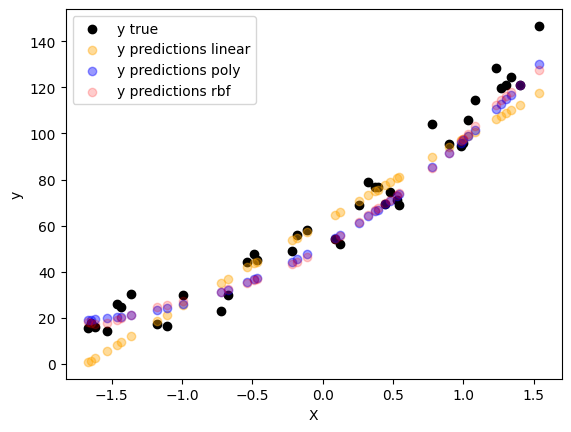

In [117]:
# Plotting this
import matplotlib.pyplot as plt

plt.scatter(X_test, y_test, alpha=1, label="y true", color='k')
my_SVM = MySVM(kernel="linear")
my_SVM.fit(X_train, y_train)
y_pred = my_SVM.predict(X_test)
plt.scatter(X_test, y_pred, alpha=0.4, label="y predictions linear", color='orange')
my_SVM = MySVM(kernel="poly", d=3)
my_SVM.fit(X_train, y_train)
y_pred = my_SVM.predict(X_test)
plt.scatter(X_test, y_pred, alpha=0.4, label="y predictions poly", color='blue')
my_SVM = MySVM(kernel="rbf", sigma=1)
my_SVM.fit(X_train, y_train)
y_pred = my_SVM.predict(X_test)
plt.scatter(X_test, y_pred, alpha=0.2, label="y predictions rbf", color='red')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()